In [1]:
import cv2
import numpy as np
from typing import TypeAlias
import matplotlib.pyplot as plt
from pycubing.enums import Color
from math import sqrt, degrees, atan2, tan, radians, dist, sin

In [2]:
MAX_IMG_AREA = 2_500_000

Contour: TypeAlias = np.ndarray
Point: TypeAlias = np.ndarray

def imshow(*imgs: cv2.Mat) -> None:
    def helper(img: cv2.Mat) -> None:
        plt.axis('off')
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.show()
    for img in imgs:
        helper(img)

def imread_capped(filename: str) -> cv2.Mat:
    img = cv2.imread(filename)
    scale_factor = min(sqrt(MAX_IMG_AREA / (img.shape[0] * img.shape[1])), 1)
    return cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

def to_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def from_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 

Remove shadows to make HSV filtering a little easier

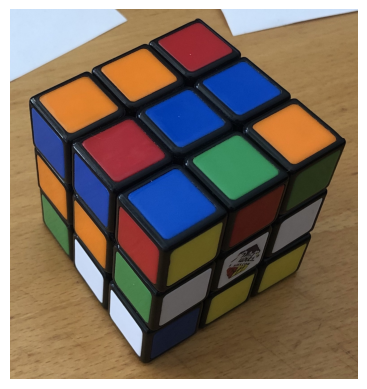

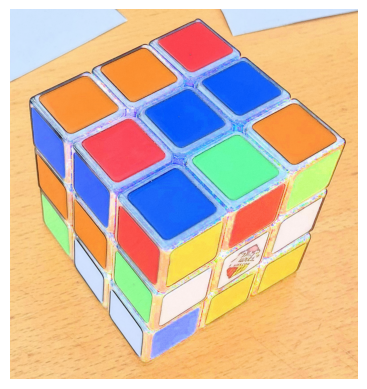

In [3]:
def get_extreme_diff(channel: np.ndarray) -> np.ndarray:
    dilated = cv2.dilate(channel, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    bg = cv2.medianBlur(dilated, 21)
    diff = 255 - cv2.absdiff(channel, bg) 
    return cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def remove_shadows(img: cv2.Mat) -> cv2.Mat:
    hsv_img = to_hsv(img)
    h, s, v = cv2.split(hsv_img)
    new_img = cv2.merge([h, s, get_extreme_diff(v)])
    return from_hsv(new_img)

img = cv2.imread("./images/cube_ugly.png")
imshow(img, remove_shadows(img))

Apply HSV filtering for each color

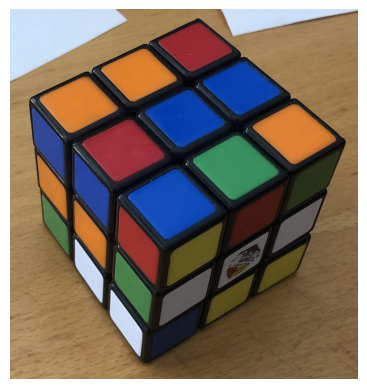

Color.RED: 


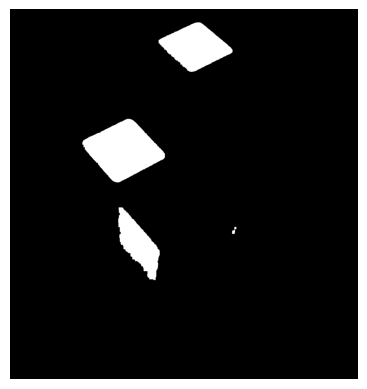

Color.ORANGE: 


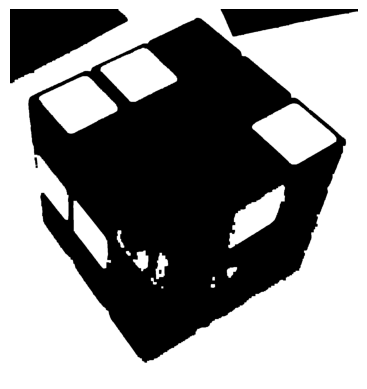

Color.BLUE: 


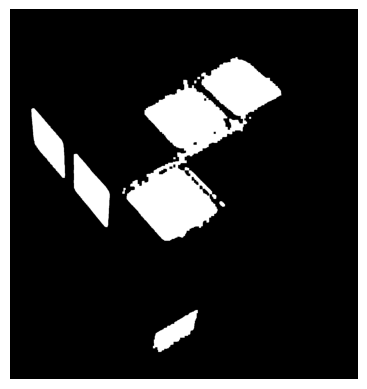

Color.GREEN: 


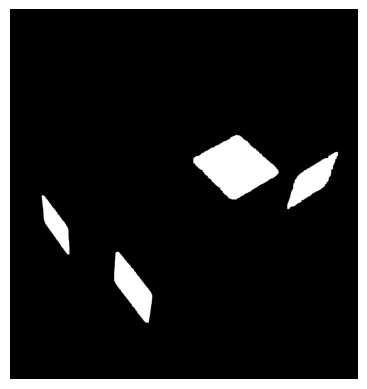

Color.WHITE: 


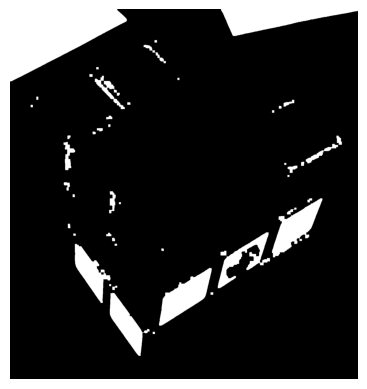

Color.YELLOW: 


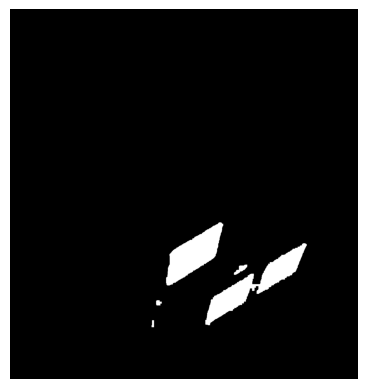

In [4]:
HSV_FILTER_COLORS = {
    Color.RED: (((170, 180), (0, 2)), (100, 255), (100, 255)),
    Color.ORANGE: (((2, 20),), (100, 255), (100, 255)),
    Color.BLUE: (((95, 125),), (100, 255), (100, 255)),
    Color.GREEN: (((40, 75),), (50, 255), (50, 255)),
    Color.WHITE: (((0, 180),), (0, 50), (150, 255)),
    Color.YELLOW: (((20, 35),), (100, 255), (100, 255)),
}

def get_hsv_masks(img: cv2.Mat) -> dict[Color, cv2.Mat]:

    def bitwise_or(*arrs: cv2.Mat):
        result = arrs[0]
        for arr in arrs[1:]:
            result = cv2.bitwise_or(arr, result)
        return result
    
    def transform_mask(mask: cv2.Mat):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        return cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    hsv_img = to_hsv(img)

    return {
        c: transform_mask(bitwise_or(*[
            cv2.inRange(hsv_img, *zip(h, s, v))
            for h in h_ranges
        ])) for c, (h_ranges, s, v) in HSV_FILTER_COLORS.items() 
    }

img = imread_capped("./images/cube_ugly.png")
imshow(img)
for c, mask in get_hsv_masks(remove_shadows(img)).items():
    print(c, ": ", sep="")
    imshow(mask)

Find the squares in which everything is

1630 20 4


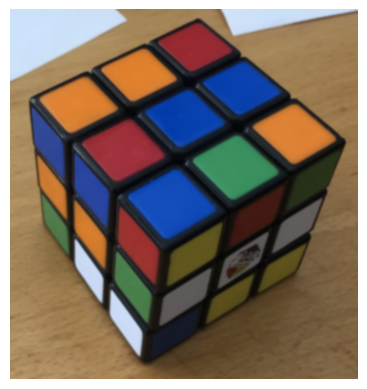

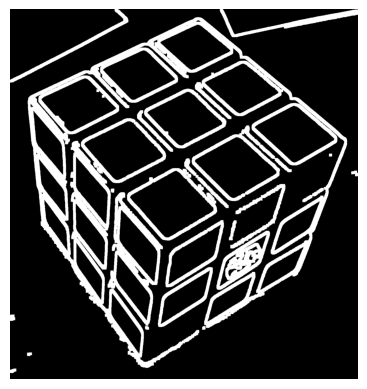

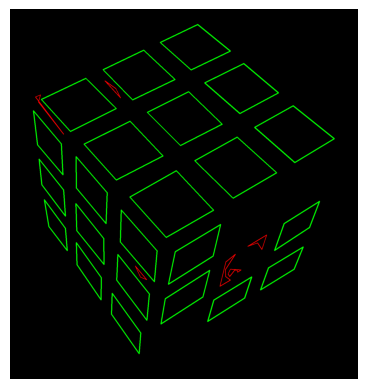

In [5]:
def filter_cubie_contours(img: cv2.Mat, contours: list[Contour], approx: list[Contour]) -> list[Contour]:

    # filter erradic, non-quadrilateral contours
    proper_contours, proper_approx = [], []
    for cnt, appr in zip(contours, approx):

        # make sure the shape approximation is a quadrilateral 
        D = len(appr) * 2
        if not 8==D:  # lol
            continue

        # make sure the approx isnt crazy different area-wise - consider removing this test
        cnt_area = cv2.contourArea(cnt, True)
        ratio = cnt_area / cv2.contourArea(appr, True)
        if min(ratio, 1/ratio) < 0.80:   # artitrary ratio thresold chosen by me
            continue

        # make sure the overlapping area isnt too bad
        overlap_reference = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(overlap_reference, [cnt], -1, (255, 255, 255), cv2.FILLED)
        cv2.drawContours(overlap_reference, [appr], -1, (0, 0, 0), cv2.FILLED)
        if (overlap_reference.sum() // 255) > (cnt_area // 5):
            continue

        proper_contours.append(cnt) 
        proper_approx.append(appr)

    # sweep through it again and cut off the ones that are too small
    avg_area = np.average([*map(cv2.contourArea, proper_approx)])
    return [*filter(lambda x: cv2.contourArea(x) > avg_area / 4, proper_approx)]

def get_cubie_contours(img: cv2.Mat, show: bool = False) -> list[Contour]:

    # computes some sizes - doesn't get too crazy because sizes are standardized
    reference_size = max(img.shape)
    blur_size = int(sqrt(reference_size) / 2)
    kernel_size = int(sqrt(reference_size) / 10)
    if show:
        print(reference_size, blur_size, kernel_size)

    # image processing to get contours
    blur = cv2.GaussianBlur(img, (blur_size + int(blur_size % 2 == 0),) * 2, kernel_size)
    edges = cv2.Canny(blur, 20, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size * 3,) * 2)
    dilated = cv2.dilate(edges, kernel)
    contours = sorted(cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, reverse=True)
    large_contours = [*filter(lambda x: cv2.contourArea(x, True) > (img.shape[0] * img.shape[1]) // 5000, contours)]
    approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True), large_contours)]
    
    # filter the contours, show if needed
    filtered = filter_cubie_contours(img, large_contours, approx)
    if show:
        display_image = np.zeros_like(img)
        cv2.drawContours(display_image, approx, -1, (0, 0, 255), 2)
        cv2.drawContours(display_image, filtered, -1, (0, 255, 0), 3)
        imshow(blur, dilated, display_image)
    return filtered

img = imread_capped("./images/cube_ugly.png")
_ = get_cubie_contours(img, show=True)

Split the small cubies by face, in order to better determine where everything is - this works optimally when the cube has three faces on display, as all three have different angles.

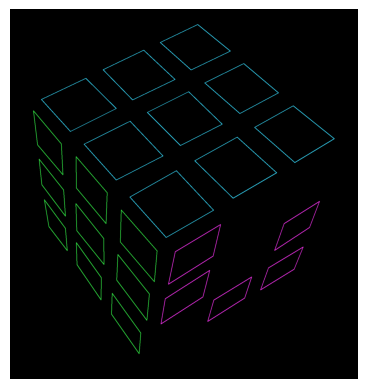

In [6]:
def compute_incline_angle(c1: np.ndarray[int, int], c2: np.ndarray[int, int]):
        """ Helper function to compute the angle between two corners, using c1 as the origin. """
        x_diff, y_diff = c2[0] - c1[0], c1[1] - c2[1]
        return degrees(atan2(y_diff, x_diff)) % 360 

ANGLE_DIFF_TOLERANCE = 18   # degrees

def get_squares_by_angle(squares: list[Contour]) -> dict[tuple[int, int], list[Contour]]:
    """ Returns a map of angle-pairs to a list of contours. This is done to seperate them into faces. """
    angle_to_squares = {}
    for appr in squares:
        appr = appr.reshape(appr.shape[0], 2)
        corner1, corner2, corner3 = appr[0], appr[1], appr[-1]
        angle_of_incline1 = compute_incline_angle(corner1, corner2)
        angle_of_incline2 = compute_incline_angle(corner3, corner1)
        for (k1, k2), v in angle_to_squares.items():
            if abs(angle_of_incline1 - k1) < ANGLE_DIFF_TOLERANCE and abs(angle_of_incline2 - k2) < ANGLE_DIFF_TOLERANCE:
                v.append(appr)
                break
        else:
            angle_to_squares[(angle_of_incline1, angle_of_incline2)] = [appr]
    return angle_to_squares

img = imread_capped("./images/cube_ugly.png")
display_img = np.zeros_like(img)
for i, v in enumerate(get_squares_by_angle(get_cubie_contours(img, show=False)).values()):
    colors = ((235, 204, 52), (226, 49, 232), (65, 217, 48), (0, 0, 200))
    cv2.drawContours(display_img, [*map(lambda x: x, v)], -1, colors[min(i, 3)], max(display_img.shape) // 1000 + 1)
imshow(display_img)

Considering restricting input to only allow for three-sided images

- Current ideas:
    - This is using the three-face strategy
    - Find the top-most piece in the cube, interpolate the locations of the other pieces
        - Ask user to hold the cube so that a tip is on the top and bottom, making sure that each extreme is on the top or bottom
    - Keep the faces unique, then we can make a map of faces to cubes
- Alernative ideas:
    - Make the user go through three different positions of showing just two parts of the cube.
        - i.e. front and right, top and left, etc
    - Then, see the top pieces and the bottom pieces
    - See if we can implement all the things    

## Method 1 - Prefered because cooler

Assume there is a lot of squares... from that it is possible to find the extreme areas to place things on

Form a grid, as grace was saying

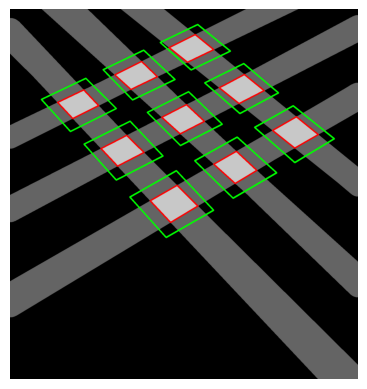

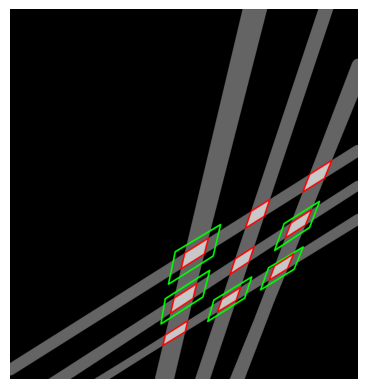

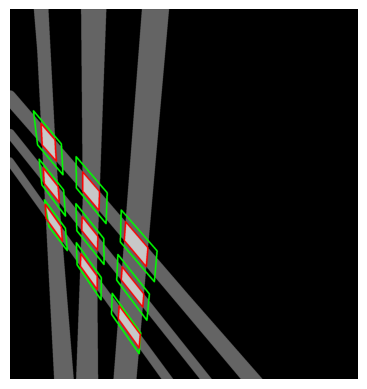

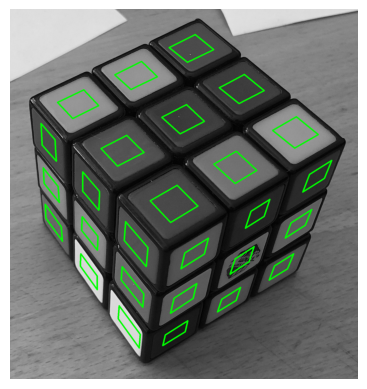

In [50]:
# https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html


def fill_line_through_contour(intersection_map: cv2.Mat, center: Point, mid_corner: Point, ang_ref_corner: Point, thick_ref_corner: Point) -> None:
    """ Draws a thick line through a contour on a given image using given reference points """

    # determine angles for use later
    line_angle = radians(compute_incline_angle(mid_corner, ang_ref_corner))
    thick_ref_angle = radians(compute_incline_angle(mid_corner, thick_ref_corner))

    # compute locations of bounding points by extrapolating using the angle 
    point1 = (0, tan(line_angle)*center[0] + center[1])
    point2 = (intersection_map.shape[1], -tan(line_angle)*(intersection_map.shape[1]-center[0]) + center[1])

    # determine the thickness using the angle of difference in the parallelogram, and plot to the map
    thickness = int(dist(mid_corner, thick_ref_corner) * abs(sin(thick_ref_angle - line_angle)))
    cv2.line(intersection_map, [*map(int, point1)], [*map(int, point2)], 100, thickness // 2)  # thickness is adjusted to avoid potential overlap of squares

def fill_empty_squares(img: cv2.Mat, face_contours: dict[tuple[float], list[Contour]], show: bool = False):

    new_face_contours = {}
    for key, squares in face_contours.items():

        # fill intersection and take some averages in tandem
        c1_c2_intersection_map = np.zeros(img.shape[:2], dtype=np.uint8)
        c2_c3_intersection_map = np.zeros(img.shape[:2], dtype=np.uint8)
        for cnt in squares:
            
            # setup stuff, getting information (getting center: https://pyimagesearch.com/2016/02/01/opencv-center-of-contour/)
            moments = cv2.moments(cnt)
            center = (int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"]))
            c1, c2, c3 = cnt[:-1]

            # fill the intersection maps
            fill_line_through_contour(c1_c2_intersection_map, center, c2, c3, c1)
            fill_line_through_contour(c2_c3_intersection_map, center, c2, c1, c3)
        
        # determine a final map and new contours that are completely accurate to the cube
        final_map = c1_c2_intersection_map + c2_c3_intersection_map
        thresh = cv2.threshold(final_map, 155, 255, cv2.THRESH_BINARY)[1]
        new_squares = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
        new_face_contours[key] = new_squares

        # show the map, green is original contours, red is the new ones
        if show:
            display_img = cv2.cvtColor(final_map, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(display_img, squares, -1, (0, 255, 0), 5)
            imshow(cv2.drawContours(display_img, new_squares, -1, (0, 0, 255), 5))

    return new_face_contours

img = imread_capped("./images/cube_ugly.png")
face_contours = fill_empty_squares(img, get_squares_by_angle(get_cubie_contours(img)), show=True)
disp_img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
for contours in face_contours.values():
    cv2.drawContours(disp_img, contours, -1, (0, 255, 0), 5)
imshow(disp_img)

In [ ]:
from enum import Enum
class FaceLocation(Enum):
    """ Quick enum to store information regarding where the faces are on the cube """
    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3

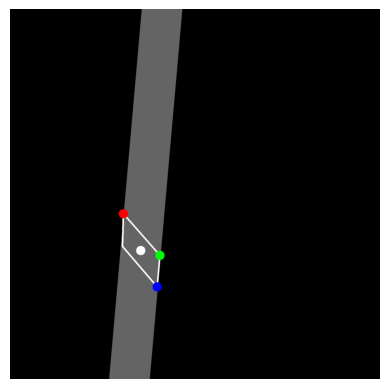

In [48]:
import numpy as np
import cv2
from math import dist

# setup stuff
filler_img = np.zeros((1600, 1600), dtype=np.uint8)
cnt = np.array([[490, 885], [648, 1065], [636, 1201], [486, 1026]])  # [[733, 712], [897, 886], [688, 1006], [528, 828]]
c1, c2, c3 = cnt[:-1]
moments = cv2.moments(cnt)
center = (int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"]))  # (x, y)

# calculating pass-through line
y_to_x_ratio = (c2[1] - c3[1]) / (c3[0] - c2[0])
point1 = (0, int(y_to_x_ratio*center[0] + center[1]))
point2 = (1600, int(-y_to_x_ratio*(1600-center[0]) + center[1]))
thickness = int(dist(c1, c2) * abs(sin(atan2(c2[1] - c3[1], c3[0] - c2[0]) - atan2(c2[1] - c1[1], c1[0] - c2[0]))))
cv2.line(filler_img, point1, point2, 100, thickness=thickness)   # problems with thickness argument

# filling circles at c1, c2, and c3
disp_img = cv2.drawContours(cv2.cvtColor(filler_img, cv2.COLOR_GRAY2BGR), [cnt], -1, (255, 255, 255), 5)
cv2.circle(disp_img, c1, 20, (0, 0, 255), -1)  # red
cv2.circle(disp_img, c2, 20, (0, 255, 0), -1)  # green
cv2.circle(disp_img, c3, 20, (255, 0, 0), -1)  # blue
cv2.circle(disp_img, center, 20, (255, 255, 255), -1)  # blue
imshow(disp_img)

In [ ]:
def get_face_color(p: Point) -> Color | None:
    pass
    # make sure we are not reading the background or something

def rotate_face_to_square(squares: list[Contour]):
    """ 
    Determine the four extreme of the cube and apply a four-point-transform to the contours.
    """ 

def get_face_squares(face_contours: dict[tuple[float], list[Contour]]) -> tuple[str, list[Point]]:

    # determine if the extreme piece is on the top or the bottom
    topmost_piece = None
    bottommost_piece = None
    for face, squares in face_contours.items():
        top_extreme_corner = min(squares, key=lambda x: min(x, key=lambda y: y[1]))
        bottom_extreme_corner = max(squares, key=lambda x: max(x, key=lambda y: y[1]))
    


In [ ]:
import time
img = cv2.imread("./images/cube_ugly.png")
blur = cv2.GaussianBlur(img, (21, 21), 5)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
imshow(*map(lambda x: cv2.bitwise_not(cv2.Canny(x, 20, 30)), [blur, gray]))

# start = time.perf_counter()
# edges = cv2.Canny(blur, 20, 30)
# end1 = time.perf_counter()
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 1)
# adjusted_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
# end2 = time.perf_counter()
# imshow(cv2.bitwise_not(edges), adjusted_thresh)
# print(end1-start, end2-end1)

NameError: name 'cv2' is not defined

In [30]:
1+112

113